## Project Description: Forest Cover Classification

In this project, you have to predict the class of forest cover (the predominant kind of tree cover) from strictly cartographic and environment variables.

The actual forest cover type for a given observation (30 x 30 meter cell) was determined from US Forest Service (USFS) Region 2 Resource Information System (RIS) data. Independent variables were derived from data originally obtained from US Geological Survey (USGS) and USFS data. Data is in raw form (not scaled) and contains categorical data for qualitative independent variables (wilderness areas and soil types).

You have further details on the data at *covertype.info* file and at https://archive.ics.uci.edu/ml/datasets/Covertype

Be aware that the final dataset has been slighly modified from the original source data.

As performance metric, you can use *AUC* in the binary classification case. For multi-class classification, check as well the confussion matrix and estimate the misclassification probabilities of different classes(check *metrics.confusion_matrix* and *metrics.classification_report* in *sklearn*).

+ Using *MultiClass_Train.csv* file build a predictive model for *Cover_Type* .
+ Try a first a binary classification to predict class #7 (Krummholz, https://en.wikipedia.org/wiki/Krummholz), which is a rare valuable habitat. After that, then try multi-variate classification to predict all classes.
+ For this analysis there is an extra test dataset. Once your code is submitted we will run a competition to see how you score in the test data. Hence have prepared also the necessary script to compute the accuracy estimate on the test data once released.

You can follow those **steps** in your first implementation:
1. *Explore* and understand the dataset. 
2. Create *dummy variables* for relevant categorical features
3. Reformat the Class_type variable into a binary one, being class #7 the target variable versus the others.
4. *Build* an initial binary model for class #7 versus the other ones and test it on the same input data. 
5. Assess expected accuracy using *cross-validation*
6. Report which variable impacts more on results 
7. Try to improve it using methods to tackle class imbalance.
8. Repeat 4., 5., 6. and 7. now with a multi-class model (EXTENDED PROJECT)
9. Produce .csv for kaggle testing 

In [1]:
#Import relevant modules
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns

import sklearn
from sklearn.linear_model import LogisticRegression, lars_path
from sklearn.preprocessing import StandardScaler, PolynomialFeatures as plf
from sklearn.model_selection import GridSearchCV, cross_val_predict as cvp
from sklearn.utils import class_weight
from sklearn.datasets import make_classification
from sklearn.metrics import mean_squared_error, make_scorer, confusion_matrix, classification_report, roc_curve, roc_auc_score, PrecisionRecallDisplay

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from collections import Counter

import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import make_classification
from sklearn.svm import LinearSVC

from imblearn.pipeline import make_pipeline
from imblearn.base import BaseSampler
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.over_sampling import (SMOTE, RandomOverSampler)
from imblearn.combine import SMOTEENN, SMOTETomek

#Compile Functions

In [2]:
#My functions

#define an evaluate function which I will use in future regressions
def binary_regression(regression, x, y, test):
    regression.fit(x, y)
    print("Intercept is:", regression.intercept_)
    y_hat = regression.predict(x)
    #Turn back into df
    y_hat = pd.DataFrame(y_hat, columns = ['Y Prediction'])
    #Get probability, one for both 0 and 1, and one for 1
    #Use [:,1] above to only return probability of one
    y_hat_prob = regression.predict_proba(x)
    y_hat_prob1 = regression.predict_proba(x)[:,1]

    #Turn back into df and print output for prediction and probability 
    y_hat_prob1 = pd.DataFrame(y_hat_prob1, columns = ['Predicted Prob of Y=1'])
    output = pd.concat([y_hat, y_hat_prob1], axis=1)
    print("TRAIN PREDICTIONS")
    print(output)

    #Do same for testing set predictions
    print("TEST PREDICTIONS")
    pred_test = regression.predict(test)
    pred_test = pd.DataFrame(pred_test, columns = ['Y Prediction Test'])
    pred_test_prob = regression.predict_proba(test)[:,1]
    pred_test_prob = pd.DataFrame(pred_test_prob, columns = ['Predicted Prob of Y=1 (Test)'])
    output_test = pd.concat([pred_test, pred_test_prob], axis=1)
    print(output_test)

    return y_hat, y_hat_prob, pred_test, pred_test_prob

def feature_impact(x, regression):
  feature_impact = pd.DataFrame({"Feature":x.columns.tolist(),"Coefficients":regression.coef_[0]})
  print(feature_impact.plot.bar(x='Feature', y='Coefficients', color='green'))
  return feature_impact



#From helper functions for ROC and AUC score
def get_auc(y, y_pred_probabilities, class_labels, column =1, plot = True):
    """Plots ROC AUC
    """
    fpr, tpr, _ = roc_curve(y == column, y_pred_probabilities[:,column],drop_intermediate = False)
    roc_auc = roc_auc_score(y_true=y, y_score=y_pred_probabilities[:,1])
    print ("AUC: ", roc_auc)
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()   

def evaluate(title, regression, X_train, y, y_pred, y_pred_prob):
    #title is a string denoting the type of data being used (i.e. undersample, oversample)
    regression_acc = regression.score(X_train, y_pred)
    print("Accuracy ({}): {:.2f}%".format(title, regression_acc * 100))
    #regression_acc * 100 because want to see as percentage
    y_pred = regression.predict(X_train)

    #from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y, y_pred)
    clr = classification_report(y, y_pred)
    #classification report is also useful to compare
    
    #plot confusion matrix
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Greens')
    #fmt allows strings 
    #vmin sets minimum value of colors to zero
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    #plot confusion matrix with percentages
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm/np.sum(cm), annot=True,fmt='.2%', cmap='Greens')    
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix with Percentages")
    plt.show()
    

    print("Classification Report:\n----------------------\n", clr)

    get_auc(y, y_pred_prob, ["Not Target", "Target"], column=1, plot=True) # Help function

    #Precision recall curve, which is appropriate for an imbalanced data set.
    #from sklearn.metrics import PrecisionRecallDisplay

    display = PrecisionRecallDisplay.from_estimator(
      regression, X_train, y, name="LinearSVC"
      ) 
    _ = display.ax_.set_title("2-class Precision-Recall curve")


def scale_min2dum(train, test, dummycolumn1, dummycolumn2):
  #from sklearn.preprocessing import StandardScaler
  #remove dummies as they don't need to be scaled
  futuredummy_train = pd.concat([train.pop(x) for x in [dummycolumn1, dummycolumn2]], axis=1)
  futuredummy_test = pd.concat([test.pop(x) for x in [dummycolumn1, dummycolumn2]], axis=1)
  #fit scaler on training set
  scaler = StandardScaler()
  scaler.fit(train)
  train = pd.DataFrame(scaler.transform(train), columns=train.columns)
  #ensure that scaler for training set is applied to test set
  test = pd.DataFrame(scaler.transform(test), columns=test.columns)
  #re-insert future dummies
  train = pd.concat([train, futuredummy_train], axis=1)
  test = pd.concat([test, futuredummy_test], axis=1)
  return train, test

#function that marks insignificant dummies as other
def insignificant_dummies_other(dummy_col, threshold):

    # removes the bind
    dummy_col = dummy_col.copy()

    # what is the ratio of a dummy in whole column
    count = pd.value_counts(dummy_col) / len(dummy_col)

    # cond whether the ratios are higher than the threshold
    mask = dummy_col.isin(count[count > threshold].index)

    # replace the ones which ratio is lower than the threshold by a special name
    dummy_col[~mask] = "Other"

    return pd.get_dummies(dummy_col, prefix=dummy_col.name)

#from sklearn.model_selection import cross_val_predict as cvp

def binary_cvp(regression, x, y, folds):
  from sklearn.model_selection import cross_val_predict as cvp
  y_pred_cv = cvp(regression, x, y, cv=folds)
  y_prob_cv = cvp(regression, x, y, cv=folds, method='predict_proba')
  #Turn back into df
  y_pred_cv = pd.DataFrame(y_pred_cv, columns = ['Y Prediction'])
  #Get probability, one for both 0 and 1, and one for 1
  #Use [:,1] above to only return probability of one
  #Need y_prob_cv for my evaluation
  y_prob_cv = regression.predict_proba(x)
  y_prob1_cv = regression.predict_proba(x)[:,1]
  #Turn back into df and print output for prediction and probability 
  y_prob1_cv = pd.DataFrame(y_prob1_cv, columns = ['Predicted Prob of Y=1'])
  output = pd.concat([y_pred_cv, y_prob1_cv], axis=1)
  print("TRAIN CVP PREDICTIONS")
  print(output)
  cmcvp =  confusion_matrix(y_pred=y_pred_cv, y_true=y, labels=[0,1])
  print ("Confusion Matrix", cmcvp)
  return y_pred_cv, y_prob_cv 

#Initial LR for initial regression
LR = LogisticRegression(penalty='l2', C=100.0, 
                           fit_intercept=True, 
                           intercept_scaling=1, 
                           solver='liblinear', max_iter=500)

In [3]:
#Create function for submitting to Kaggle
def submission(predictions, submission_filename):
  kaggleattempt = predictions.copy()
  kaggleattempt.index +=61006
  kaggleattempt.rename(columns={ kaggleattempt.columns[0]: 'Cover_Type' }, inplace = True)
  return kaggleattempt.to_csv(submission_filename, index=True, index_label='Index')

#Create function for submitting to Kaggle
def submission_fromnp(predictions, submission_filename):
  kaggleattempt = predictions.copy()
  kaggleattempt.index +=61006
  kaggleattempt.rename(columns={ kaggleattempt.columns[0]: 'Cover_Type' }, inplace = True)
  return kaggleattempt.to_csv(submission_filename, index=True, index_label='Index')

# Explore and understand the dataset

## Import and read the data

In [4]:
train = pd.read_csv('/content/MultiClass_Train.csv', index_col='Index')
test = pd.read_csv('/content/MultiClass_Test.csv', index_col=False)
#Index_col=False prevents pandas from characterizing the first column as Index, and instead creates a new index starting from 0
test = test.drop(columns=['Index'], axis=1)
#Index numbers start around 61006 for test set, so resetting the index to start test at zero using the above method

In [5]:
#Info shows range, column names, non-null values and variable type
train.info()
test.info()

#Head shows first five rows
train.head()
test.head()

#Show mean values of variables
train.mean()
test.mean()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61006 entries, 0 to 61005
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   Elevation              61006 non-null  int64
 1   Aspect                 61006 non-null  int64
 2   Slope                  61006 non-null  int64
 3   Horiz_dist_hydro       61006 non-null  int64
 4   Vertical_dist_hydro    61006 non-null  int64
 5   Horiz_dist_roadways    61006 non-null  int64
 6   Hillshade_9am          61006 non-null  int64
 7   Hillshade_Noon         61006 non-null  int64
 8   Hillshade_3pm          61006 non-null  int64
 9   Horiz_dist_firepoints  61006 non-null  int64
 10  Cover_Type             61006 non-null  int64
 11  Wilderness_Area        61006 non-null  int64
 12  Soil_Type              61006 non-null  int64
dtypes: int64(13)
memory usage: 6.5 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13073 entries, 0 to 13072
Data columns (total 12 col

Elevation                2959.776409
Aspect                    156.848313
Slope                      14.164538
Horiz_dist_hydro          266.416507
Vertical_dist_hydro        46.155358
Horiz_dist_roadways      2355.662969
Hillshade_9am             211.957393
Hillshade_Noon            223.245162
Hillshade_3pm             142.659833
Horiz_dist_firepoints    1993.006578
Wilderness_Area             2.109615
Soil_Type                  24.409546
dtype: float64

## Visualize data

### Visualize categoricals

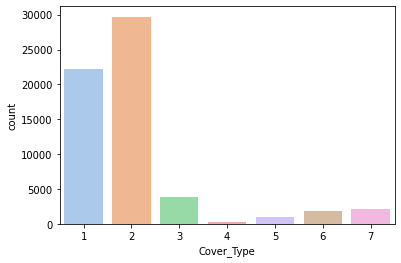

In [6]:
#Visualize frequency of cover_types. Could have also used the training set for this
cover_types = train.filter(['Cover_Type'], axis=1)
cover_types.value_counts()
sns.countplot(x=cover_types['Cover_Type'], data=cover_types, palette='pastel')

Text(0.5, 1.0, 'Wilderness Area Distribution - Testing Data')

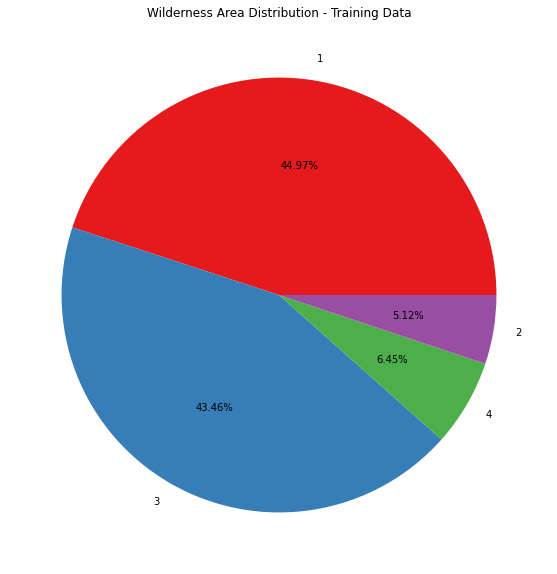

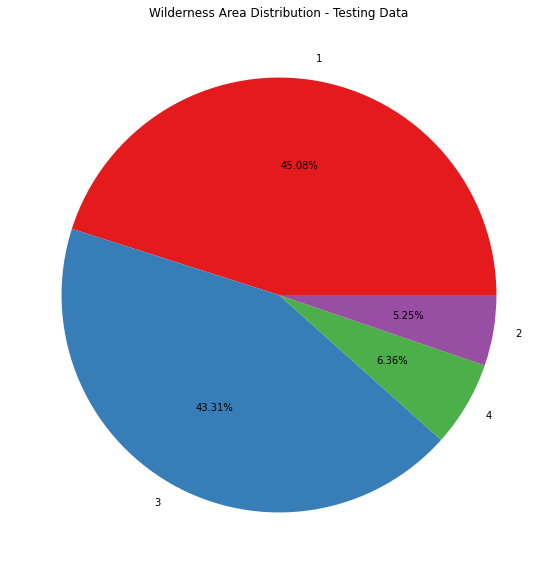

In [7]:
#Pie chart visualization of other categorical variables

#Start with Wilderness Area using value_counts

cmap = sns.color_palette("Set1", as_cmap=True)(np.arange(7))
#Use Set1 to differentiate from other categorical variables
plt.figure(figsize=(10, 10))
plt.pie(train['Wilderness_Area'].value_counts().values,
colors=cmap,
labels=train['Wilderness_Area'].value_counts().keys(),
autopct='%.2f%%')
#To 2 decimal points
plt.title("Wilderness Area Distribution - Training Data")
#plt.show()

cmap = sns.color_palette("Set1", as_cmap=True)(np.arange(7))
#Use Set1 to differentiate from other categorical variables
plt.figure(figsize=(10, 10))
plt.pie(test['Wilderness_Area'].value_counts().values,
colors=cmap,
labels=test['Wilderness_Area'].value_counts().keys(),
autopct='%.2f%%')
#To 2 decimal points
plt.title("Wilderness Area Distribution - Testing Data")
#plt.show()

The training and testing sets have a nearly identical make-up of Wilderness_Area.

Note, from data information given at 
https://archive.ics.uci.edu/ml/datasets/Covertype 

"This study area includes four wilderness areas located in the Roosevelt National Forest of northern Colorado. These areas represent forests with minimal human-caused disturbances, so that existing forest cover types are more a result of ecological processes rather than forest management practices. 

Some background information for these four wilderness areas: Neota (area 2) probably has the highest mean elevational value of the 4 wilderness areas. Rawah (area 1) and Comanche Peak (area 3) would have a lower mean elevational value, while Cache la Poudre (area 4) would have the lowest mean elevational value."

This indicates there must be correlation between wilderness_areas and elevation

Text(0.5, 1.0, 'Soil Type Distribution - Testing Data')

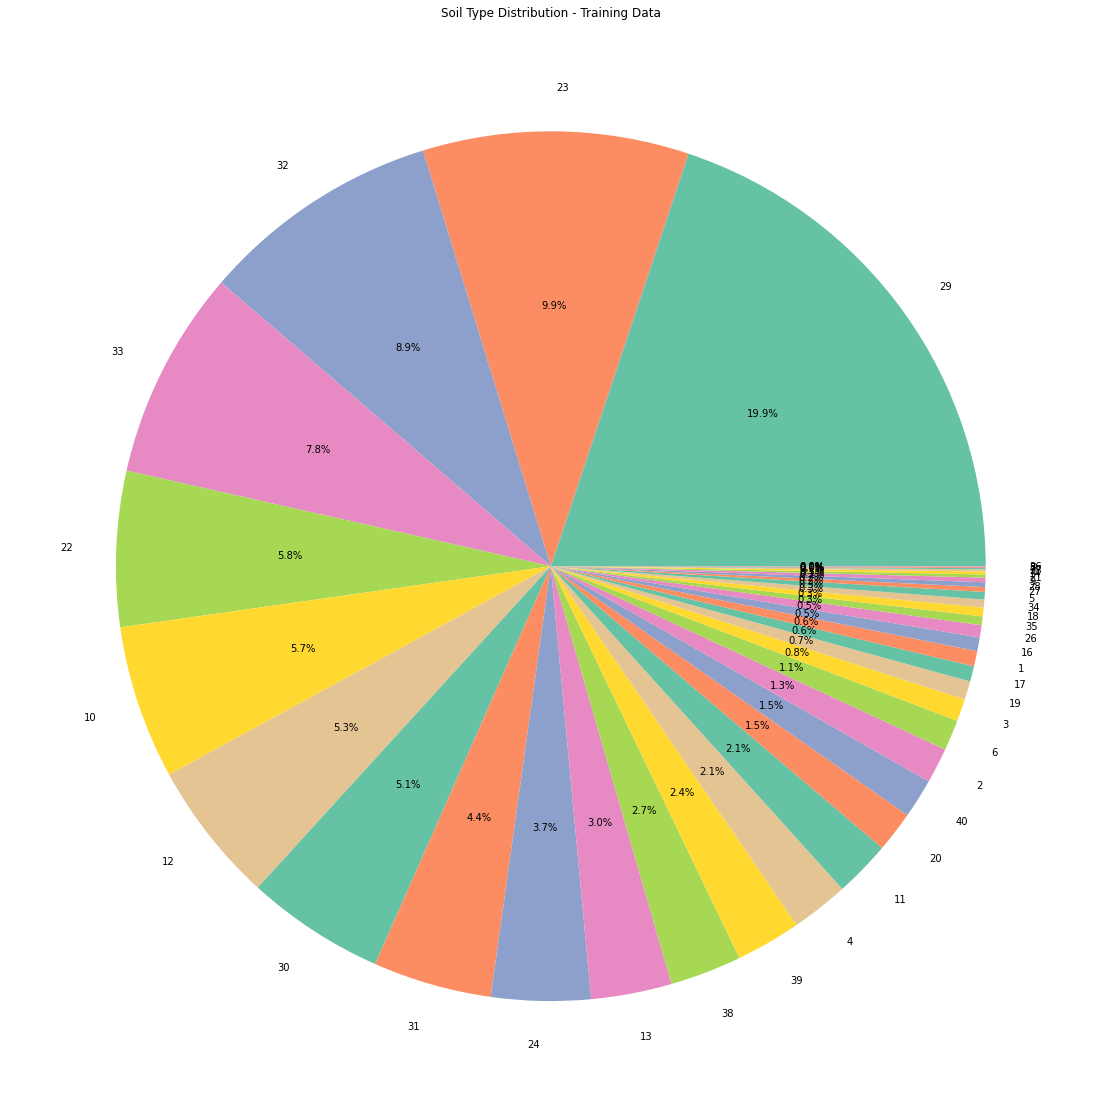

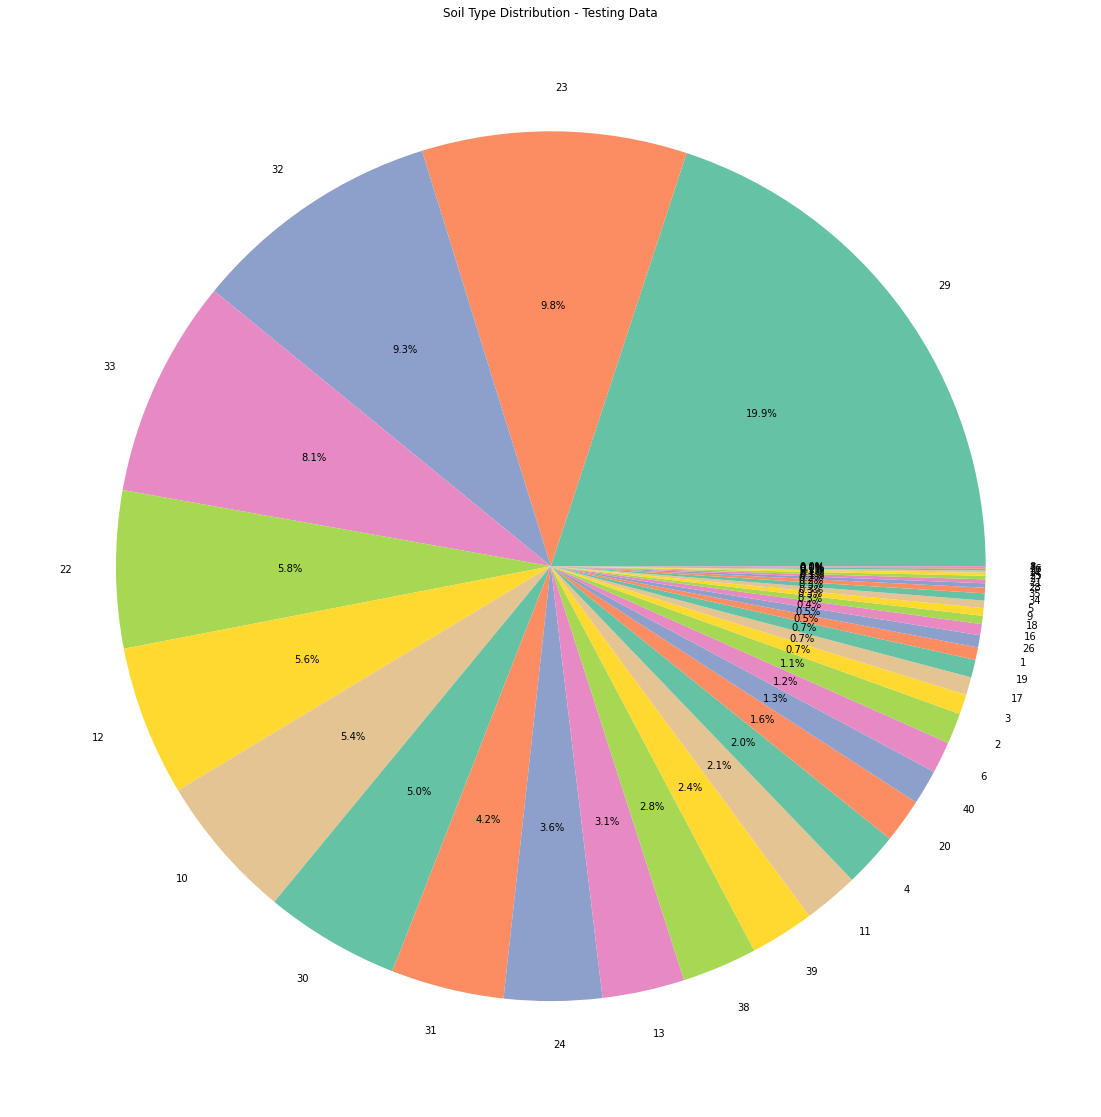

In [8]:
#Visualization of Soil_Type in training set using value_counts
cmap = sns.color_palette("Set2", as_cmap=True)(np.arange(7))
#Use Set2 to differentiate from prior categoricals
plt.figure(figsize=(20, 20))
plt.pie(train['Soil_Type'].value_counts().values,
colors=cmap,
labels=train['Soil_Type'].value_counts().keys(),
autopct='%.1f%%')
#This gives the decimal points used
plt.title("Soil Type Distribution - Training Data")
#plt.show()

#Visualization of Soil_Type in testing set using value_counts
cmap = sns.color_palette("Set2", as_cmap=True)(np.arange(7))
#Use Set2 to differentiate from prior categoricals
plt.figure(figsize=(20, 20))
plt.pie(test['Soil_Type'].value_counts().values,
colors=cmap,
labels=test['Soil_Type'].value_counts().keys(),
autopct='%.1f%%')
#This gives the decimal points used
plt.title("Soil Type Distribution - Testing Data")
#plt.show()

Although not pretty for very small values, the above is informative, indicating that there are a large number of soil types that are infrequent, and several dominant soil types. Also, the training and testing sets have very similar soil types. I will be able to combine many of these smaller variables below.

### Visualize variable distribution densities




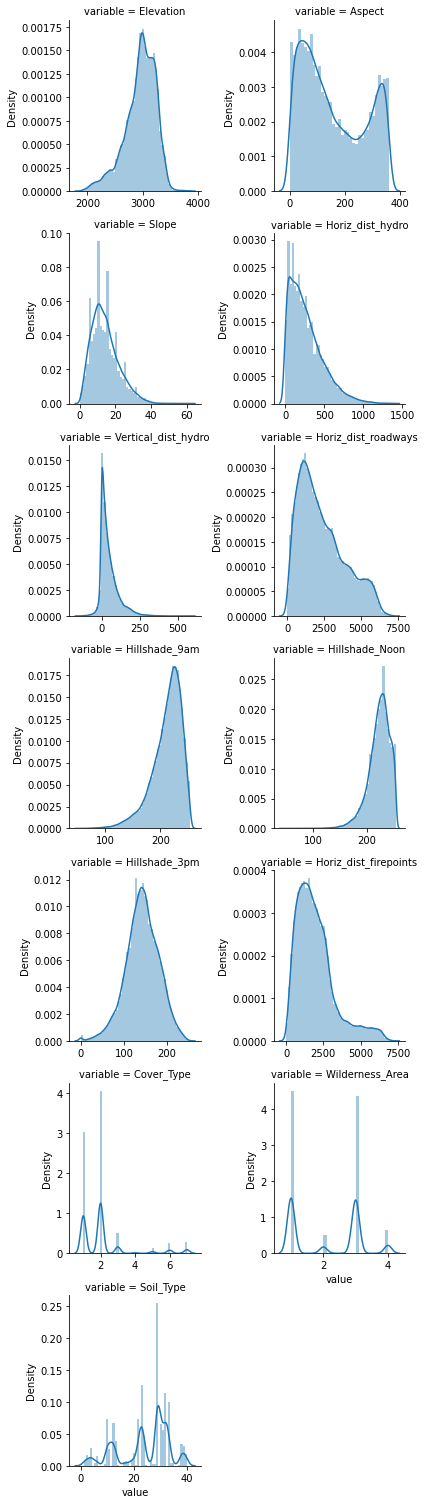

In [9]:
dens_data = [f for f in train.columns]
f = pd.melt(train, value_vars=dens_data)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False)
g = g.map(sns.distplot, "value")

The above indiactes a very nice, normal looking distribution for Hillshade_3pm in particular, with some others displaying both left and right skewness

### Correlation Matrix

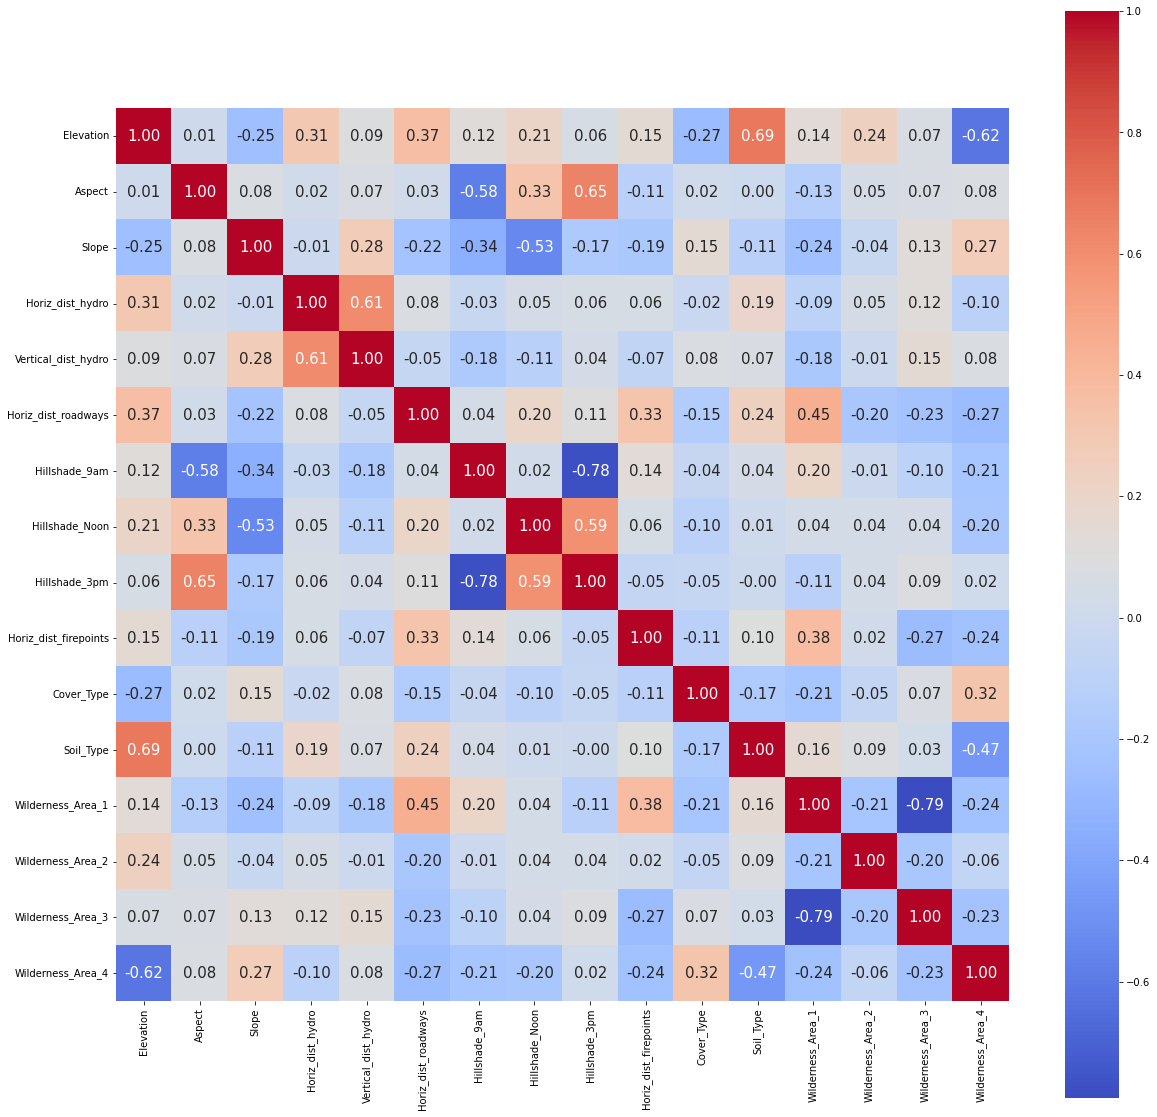

In [10]:
#Create a correlation matrix to see if variables are correlated 
corr_data = train.copy()
corr_data = pd.get_dummies(data=corr_data, columns=['Wilderness_Area'])
correlation_matrix = corr_data.corr()
plt.figure(figsize=(20,20))
sns.heatmap(correlation_matrix, cbar = True, square= True, fmt='.2f', annot=True, annot_kws={'size':15}, cmap = 'coolwarm')

I can disregard Soil_Type as it is a categorical variable

There is a positive correlation of .65 for Hillshade_3pm and Aspect. 

As predicted, Wilderness_Area and Elevation have some correlation, particularly Wilderness_Area 4 and negative correlation of .69 with elevation. 

There is a fairly high negative correlation between Hillshade_9am and Hillshade_3pm, which makes perfect sense given the movement of the sun throughout the day. Hillshade_9am and Aspect also have a negative correlation of -.58.

# Data Preprocessing

## Turn target binary

In [11]:
def separate_binary(train, column, target_value):
  y = train[column]
  x = train.drop([column], axis=1)
  #x = x
  y = y == target_value
  y = y.astype(int)

  return x, y
  
x_train, y = separate_binary(train, 'Cover_Type', 7)
#Did not call it y_train because there is no y_test, so more efficient for me to leave y

##Scale data

In [12]:
#from function defined in beginning
x_train, test = scale_min2dum(x_train, test, 'Wilderness_Area', 'Soil_Type')

## Deal with insignifcant dummies

In [13]:
#function that marks insignificant dummies as other
def insignificant_dummies_other(dummy_col, threshold):

    # removes the bind
    dummy_col = dummy_col.copy()

    # what is the ratio of a dummy in whole column
    count = pd.value_counts(dummy_col) / len(dummy_col)

    # cond whether the ratios are higher than the threshold
    mask = dummy_col.isin(count[count > threshold].index)

    # replace the ones which ratio is lower than the threshold by a special name
    dummy_col[~mask] = "Other"

    return pd.get_dummies(dummy_col, prefix=dummy_col.name)

In [14]:
train_soils = train['Soil_Type']
test_soils = test['Soil_Type']
#Glancing at pie chart above, I know that .031 threshold will make same changes to test and training set
train_soils = insignificant_dummies_other(train_soils, threshold=.031)
test_soils = insignificant_dummies_other(test_soils, threshold=.031)
#drop one to avoid dummy variable trap. This was not in the function because I don't want to drop first
train_soils = train_soils.drop(['Soil_Type_10'], axis=1)
test_soils = test_soils.drop(['Soil_Type_10'], axis=1)
#Now drop original from dataframe
x_train = x_train.drop(['Soil_Type'], axis=1)
test = test.drop(['Soil_Type'], axis=1)

#Do same for Wilderness_Area just in case more data is added down the line, though there will be no other column
train_wilderness = x_train['Wilderness_Area']
test_wilderness = test['Wilderness_Area']
train_wilderness = insignificant_dummies_other(train_wilderness, threshold=.01)
test_wilderness = insignificant_dummies_other(test_wilderness, threshold=.01)
#drop Wilderness_Area_4 to avoid dummmy variable trap. I did this manually instead of Dropfirst because
#looking at the data, Cover_Type 7 never occurs with Wilderness_Area_4, so for interpretability the other 3 will be useful
train_wilderness = train_wilderness.drop(['Wilderness_Area_4'], axis=1)
test_wilderness = test_wilderness.drop(['Wilderness_Area_4'], axis=1)
x_train = x_train.drop(['Wilderness_Area'], axis=1)
test = test.drop(['Wilderness_Area'], axis=1)

In [15]:
#Add soil_type and wilderness dummies back into dataframe. Could also wait to do this until after plf transform
x_train = pd.concat([x_train, train_soils], axis=1)
test = pd.concat([test, test_soils], axis=1)
x_train = pd.concat([x_train, train_wilderness], axis=1)
test = pd.concat([test, test_wilderness], axis=1)

# Get Predictions

## Tune hyperparameters

To find the best parameters for my regression, I can use GridsearchCV or LogisticRegressionCV. I've chosen to run both to see what my best options are, as they can give different reults

#### GridSearchCV

GridSearchCV is way to tune the hyperparameters. You are able to try out different combinations of values for hyperparameters and it will be able to output the best one. GridSearchCV uses cross-validation. Cross-validation, which is used as well to assess model accuracy, is run by first  splitting the data set into a number of k-parts. Out of the k-parts, it will use 1 fold for testing and k minus one folds for training. It does this over a number of iterations (which is specified by cv=) and can output the mean of your desired metrics, like accuracy and precision.

In the below, C refers to regularization strength inverse. The smaller the value the stronger the regularization.


In [16]:
# Grid search cross validation
#from sklearn.model_selection import GridSearchCV
#from sklearn.linear_model import LogisticRegression
grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}# l1 lasso l2 ridge
logreg=LogisticRegression(max_iter=1000)
logreg_cv=GridSearchCV(logreg,grid,cv=10)
logreg_cv.fit(x_train,y)

print("tuned hyperparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
70 fits failed out of a total of 140.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
70 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 449, in _check_solver
    % (solver, penalty)
ValueError: Solve

tuned hyperparameters :(best parameters)  {'C': 10.0, 'penalty': 'l2'}
accuracy : 0.9772808972460844


According to the above, my best parameters are C: 10, which is the inverse of regularization strength. So lambda is 1/10, or .1

Penalty L2 (Ridge). Ridge will add “squared magnitude” of coefficient as a penalty term to the loss function

Accuracy given is .977

#### LogisticRegressionCV

I can also try LogisticRegressionCV to tune the hyperparameters

In [ ]:
#Try LogisticRegressionCV
from sklearn.linear_model import LogisticRegressionCV

clf = LogisticRegressionCV(
Cs=list(np.power(10.0, np.arange(-10, 10)))
#above checks all parameters between and 10
,penalty='l2'
,scoring='roc_auc'
,cv=5
,random_state=59
,max_iter=10000
,fit_intercept=True
,solver='newton-cg'
,tol=10)
clf.fit(x_train, y)

print ('Max auc_roc:', clf.scores_[1].max())

From the above, my max auc_roc accuracy is 0.97731, which is similar to the GridSearchCv.

I'll likely need to make some changes

In [ ]:
clf.fit(x_train, y)

In [ ]:
print(clf.C_)
clf.scores_
#Below shows the output of the various AUC scores compiled

### Refit the model using new lambda



In [ ]:
#Import LogisticRegression and define regression run as LR2 (2 denotes penalty l2)

LR2 = LogisticRegression(penalty='l2', C=1.0, #or C=searchCV.C_[0], 
                           fit_intercept=True, 
                           solver='liblinear', max_iter=5000)
#Note solver liblinear is only to be used for one vs many schemes according to sklearn

## Run initial logistic regression

Below I will run an initial logistic regression without polynomials, undersampling or oversampling to have a baseline comparison

In [ ]:
y_hat_sc, y_hat_prob_sc, pred_test_sc, pred_test_prob_sc = binary_regression(LR2, x_train, y, test)

### Report which variable impacts more on results



In [ ]:
feature_impact(x_train, LR2)

### Evaluate initial model

The evaluate function will use the get_auc function and then ouput useful information, such as the confusion matrix, the classification report, the precision recall curve, and the roc curve. 

In [ ]:
#Evaluate initial model
#from sklearn.metrics import classification_report
evaluate('Imbalanced Scaled', LR2, x_train, y, y_hat_sc, y_hat_prob_sc)

Not horrible! But need to assess further

### Assess using cross-validation

As noted above, cross-validation, which is used as well to assess model accuracy, is run by first splitting the data set into a number of k-parts. Out of the k-parts, it will use 1 fold for testing and k minus one folds for training. It does this over a number of iterations (which is specified by cv=) and can output the mean of your desired metrics, like accuracy and precision.

For purpose of this notebook and best practices however, I will use a 10-fold CV to improve speed and efficiency as opposed to using too many folds


In [ ]:
y_pred_cv, y_prob_cv = binary_cvp(LR2, x_train, y, 10)

In [ ]:
evaluate('Imbalanced CVP', LR2, x_train, y, y_pred_cv, y_prob_cv)

#Note accuracy is nearly 100%, which is misleading because of the unbalanced data.

Using cross validation, my predictions remained the same true negatives and true positives (incidence of Type 2 and Type 1 error fell slightly). My F1 score for predicting Krummholz forest type is still low (.63).

Because of the class-imbalance, my algorithm is very good at predicting when forests are not Krummholz as indicated by the high precision (indicating a low false positive rate, or Type 1 Error). This is easy though. The above recall is not very high, which indicates my false negative rate (Type 2 Error). 

Precision and recall are useful metrics when classes are very imbalanced. Thus, the algorithm is not good at predicting when forests are Krummholz (low precision). Sklearn indicates that "A system with high precision but low recall is just the opposite, returning very few results, but most of its predicted labels are correct when compared to the training labels."

Above, I have also plotted a precision recall curve, which plots precision on the y and recall on the x axis. In a precision recall curve, the higher the precision, the fewer number false positives. The higher the recall, the fewer number of false negatives. The curve looks ok, but can be improved to have a larger area

In other words, it's fairly simple for the algorithm to have high precision when there are so few Krummholz observations. We therefore most deal with class-imbalance.

# Undersampling and Oversampling

Undersampling and oversampling are both methods that can be used to make Cover_Type instances evenly distributed across all types. This is useful in some ways, but also can cause significant bias.

*   Oversampling can cause overfitting, because it duplicates the smaller classes so that there are enough observations to match the majority class

*   Undersampling results in information loss because it deletes observations from the majority class so that it coincides with minority class

Demonstrated visually below:

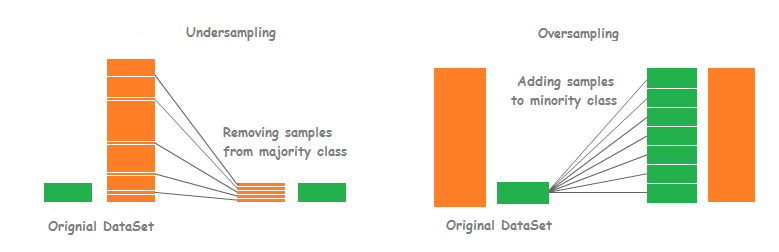

## Undersampling
An undersampling technique will be used to cut the data down to equal number of observations for each cover_type. Although I lose a lot of data, the observations of Cover_Type will be equal across types. 


### Random Undersampler from Imblearn

According to sklearn, this will under-sample the majority class by randomly picking samples with or without replacement.



In [ ]:
#Install imblearn
#pip install imbalanced-learn

In [ ]:
#Create new data with y so I can make changes to a new dataset with representative number of y-variables
us_train = pd.concat([cover_types, x_train], axis=1)
rus_train, y_rus = separate_binary(us_train, 'Cover_Type', 7)

In [ ]:
# Create an instance of RandomUnderSampler, fit the training data and apply Logistics regression
from imblearn.under_sampling import RandomUnderSampler

RUS = RandomUnderSampler()
rus_train, y_rus = RUS.fit_resample(rus_train, y_rus)

y_hat_rus, y_prob_rus, pred_test_rus, pred_prob_rus = binary_regression(LR, rus_train, y_rus, test)

In [ ]:
evaluate('Random Undersampler', LR2, rus_train, y_rus, y_hat_rus, y_prob_rus)

In [ ]:
#Assess accuracy using CVP
rus_pred_cv, rus_prob_cv = binary_cvp(LR2, rus_train, y_rus, 10)

In [ ]:
evaluate('Random Undersampler CVP', LR, rus_train, y_rus, rus_pred_cv, rus_prob_cv)

It seems that my Random Undersampler improved my original scores and my curve, with F-1 Scores of .93 using CVP.

However, I'll try a few more undersampling techniques to see what's best.

### Cut down data and eliminate Cover_Type 4

Below I will try undersampling with a different more manual method I discovered. In this scenario, I will eliminate Cover_Type_4 as there are only 295 observations of it, and using an undersampling technique that drops me to 295 observations will results in too much data loss

In [ ]:
#From below I know that class 4 has the least number of observations with only 295.
cover_types.value_counts()

In [ ]:
#Since I do not care about predicting class 4, I will  remove class 4 as it only has 295 observations
#and I do not want to cut every class down to 295
us_train = us_train[us_train.Cover_Type != 4]

In [ ]:
#Get smallest class size in df
class_992 = np.min(us_train['Cover_Type'].value_counts().values)
print("Size of smallest class:", class_992)

In [ ]:
#Cut down data to have Cover_Type 7 be evenly distributed

class_subsets = [us_train.query("Cover_Type == " + str(i)) for i in (list(range(1,4)) + list(range(5,8)))]

#This works by creating lists of subsets of data based on Cover_Type using the query function 
#and a for loop. An iterable is returned so it needs to be #converted to a list to function properly. 
#The + is used to skip over Cover_Type 4 which was removed

#Note cover_type 7 is the 6th item in my list
for i in range(6):
    class_subsets[i] = class_subsets[i].sample(class_992, replace=False, random_state=59)

us_train = pd.concat(class_subsets, axis=0).sample(frac=1.0, random_state=59).reset_index(drop=True)

In [ ]:
#Double check that all Cover_types have 992 observations
us_train['Cover_Type'].value_counts()

### Run regression on undersampled data with 992 observations each

In [ ]:
us_train, y_us = separate_binary(us_train, 'Cover_Type', 7)

In [ ]:
y_pred_us, y_prob_us, pred_test_us, pred_prob_us = binary_regression(LR2, us_train, y_us, test)

In [ ]:
evaluate('Undersampled Regression 995 Obs', LR, us_train, y_us, y_pred_us, y_prob_us)

In this scenario, my F1 score for predicting the non-Krummholz classes was increased to .98, however the True Positive predictor (of greater importance) was reduced to .88, as was my recall. It looks like the random undersampler was a better option. WIll check the CVP

In [ ]:
us_pred_cv, us_prob_cv = binary_cvp(LR2, us_train, y_us, 10)

#y_hat_us_cv = cvp(LR, us_train, y_us, cv=50)
#y_prob_us_cv = cvp(LR, us_train, y_us, cv = 5, method = 'predict_proba')
evaluate('Undersampled CVP 995 Obs', LR2, us_train, y_us, us_pred_cv, us_prob_cv)

CVP confirms that technique was not as good as the random undersampler for my F1 score of the true positive. 

###Eliminate Cover_Type 4 and 5

Perhaps eliminating Cover_Type_5 will improve things, as Cover_Type_5 is also rare  (only 1865 observations), and by dropping it I will lose less data. Use exact same technique.

In [ ]:
us_train2 = pd.concat([cover_types, x_train], axis=1)
#Drop cover types 4 and 5
us_train2 = us_train2[us_train2.Cover_Type != 4]
us_train2 = us_train2[us_train2.Cover_Type != 5]
#get min class size of 1865
class_1865 = np.min(us_train2['Cover_Type'].value_counts().values)

In [ ]:
#Cut down data less to have Cover_Type 7 be evenly distributed

class_subsets = [us_train2.query("Cover_Type == " + str(i)) for i in (list(range(1,4)) + list(range(6,8)))]

#This works by creating lists of subsets of data based on Cover_Type using the query function 
#and a for loop. An iterable is returned so it needs to be #converted to a list to function properly. 
#The + is used to skip over Cover_Type 4 which was removed

#Note cover_type 7 is the 5th item in my list
for i in range(5):
    class_subsets[i] = class_subsets[i].sample(class_1865, replace=False, random_state=59)

#add new class subsets to df
us_train2 = pd.concat(class_subsets, axis=0).sample(frac=1.0, random_state=59).reset_index(drop=True)

In [ ]:
#separate y
us_train2, y_us2 = separate_binary(us_train2, 'Cover_Type', 7)
#run regression
y_hat_us2, y_prob_us2, test_pred_us2, test_prob_us2 = binary_regression(LR2, us_train2, y_us2, test)
evaluate('Undersampled Regression 1865 obs.', LR2, us_train2, y_us2, y_hat_us2, y_prob_us2)

In [ ]:
#Evaluate using CVP
y_hat_us_cv2, y_prob_us_cv2 = binary_cvp(LR2, us_train2, y_us2, 10)
evaluate('Undersampled Cross-Val-Pred 1865 Obs', LR2, us_train2, y_us2, y_hat_us_cv2, y_prob_us_cv2)

In the above using 1865 observations for each class and eliminating class types 4 and 5, I ended up with a lower AUC score and lower F1-score. Thus, I will stick with the random undersampler which I used in the first instance.

## Oversampling

Oversampling can also be attempted. In this case, I'll try the previous method and the SMOTE method

### Random oversampler

In [ ]:
#Reconcatenate and separate into binary
os_train = pd.concat([cover_types, x_train], axis=1)
ros_train, y_ros = separate_binary(os_train, 'Cover_Type', 7)

In [ ]:
# Create an instance of RandomUnderSampler, fit the training data and apply Logistics regression
from imblearn.over_sampling import RandomOverSampler

ROS = RandomOverSampler()
ros_train, y_ros = ROS.fit_resample(ros_train, y_ros)

y_hat_ros, y_prob_ros, pred_test_ros, pred_prob_ros = binary_regression(LR2, ros_train, y_ros, test)

In [ ]:
evaluate("Random Oversampler", LR2, ros_train, y_ros, y_hat_ros, y_prob_ros)

My AUC score went up slightly and I had F-1 Score of .92 for the true positive and negative

In [ ]:
y_hat_ros_cv, y_prob_ros_cv = binary_cvp(LR2, ros_train, y_ros, 10)

In [ ]:
evaluate("Random Oversampler CVP", LR2, ros_train, y_ros, y_hat_ros_cv, y_prob_ros_cv)

### SMOTE

I have more confidence in SMOTE than randomly oversampling because it creates synthetic data, so I don't have many identical data points with a standard oversampling method.

According to a Medium resource, the generation of synthetic data will work by first selecting random data from the minority class.
Then, the Euclidean distance between the random data and its k nearest neighbors will be calculated using k-nearest neighbor technique. Then, the difference will be multiplied with a random number between 0 and 1, then the result will be added to the minority class as a synthetic sample.

SMOTE will ideally reduce false negatives, but potentially increase recall (false positives) at the expense of precision (false negatives)

In [ ]:
from imblearn.over_sampling import SMOTE
# create smote datasets
smote_train = pd.concat([cover_types, x_train], axis=1)
smote_train, y_smote = separate_binary(os_train, 'Cover_Type', 7)

# Create an instance of SMOTE, fit the training data and apply #Logistics regression
smoter = SMOTE(random_state=59, sampling_strategy='minority', k_neighbors=5)
smote_train, y_smote = smoter.fit_resample(smote_train, y_smote)

In [ ]:
smoter_classifier = LR2

smote_pred, smote_prob, smote_test, smote_test_prob = binary_regression(smoter_classifier, smote_train, y_smote, test)

In [ ]:
evaluate('SMOTE', smoter_classifier, smote_train, y_smote, smote_pred,smote_prob)

Best scores yet! .93 F1 for the True Positive

In [ ]:
kaggleattempt1_binary.to_csv("js_binary_1.csv", index=True, index_label='Index')


In [ ]:
#Assess accuracy using CVP

y_hat_smote_cv, y_prob_smote_cv = binary_cvp(smoter_classifier, smote_train, y_smote, 10)

In [ ]:
evaluate('SMOTE CVP', smoter_classifier, smote_train, y_hat_smote_cv, y_prob_smote_cv)

# Add Polynomial Features

In order to try and improve the above predictions, I will add polynomial features and run my best model on the new dataset

In [ ]:
#Add Polynomial Features (option to move this cell to before dummies have been re-added, but chose not to)
from sklearn.preprocessing import PolynomialFeatures
# perform a polynomial features transform of the dataset
poly = PolynomialFeatures(degree=2)
x_plf = poly.fit_transform(x_train)[:,1:]

test_plf = poly.fit_transform(test)[:,1:] # drop the intercept column
print(x_plf)
#intercept is not included

test_plf.shape

## Re-scale Data

In [ ]:
#Must ensure to re-scale my data after adding many polynomial features
Scaler = StandardScaler()
Scaler.fit(x_plf)
x_plf = Scaler.transform(x_plf)
test_plf = Scaler.transform(test_plf)

## Tune hyperparameters



Pipeline was used below. According to sklearn:
"The purpose of the pipeline is to assemble several steps that can be cross-validated together while setting different parameters. For this, it enables setting parameters of the various steps using their names and the parameter name separated by a '__', as in the example below. A step’s estimator may be replaced entirely by setting the parameter with its name to another estimator, or a transformer removed by setting it to 'passthrough' or None."

In [ ]:
#The below code initially ran for 7 hours and still did not get a result, so for the sake
#of submission I had to lower some parameters

from sklearn.linear_model import LogisticRegression

LR_poly = LogisticRegression(
    penalty='l2', 
    fit_intercept=True,
    max_iter = 500,
    )
x_train = x_plf.copy()
n_folds = 10 # remember that for this dataset this is leave-one-out
lambdas = np.array([0.1, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2])
tuned_parameters = {'C': 1/lambdas} ## dictionary
clf = GridSearchCV(LR_poly, tuned_parameters, scoring = 'roc_auc', cv=n_folds, refit=False)
clf.fit(x_plf, y)

print(clf.best_score_)
print(clf.best_params_) 
#lambda = 1/C)
clf.cv_results_['mean_test_score']

## SMOTE with Polynomials

In [ ]:
# create smote datasets
smote_train2 = x_plf
#y_smote already defined earlier
# Create an instance of SMOTE, fit the training data and apply #Logistics regression
smoter = SMOTE(random_state=59, sampling_strategy='minority', k_neighbors=5)
smote_train2, y_smote2 = smoter.fit_resample(x_plf, y)

smoter_classifier = LR2

smote_pred2, smote_prob2, smote_test2, smote_test_prob2 = binary_regression(smoter_classifier, smote_train2, y_smote2, test_plf)

In [ ]:
evaluate("SMOTE Polynomial", smoter_classifier,smote_train2, y_smote2, smote_pred2, smote_prob2)

Looks like this did a great job with highest scores yet. Checking below with CVP (used 5-fold to save time given size of data set)

In [ ]:
y_poly_smote_cv, y_probpoly_smote_cv = binary_cvp(smoter_classifier, smote_train2, y_smote2, 5)
evaluate("Smote CVP", smoter_classifier, smote_train2, _poly_smote_cv, y_probpoly_smote_cv)

In [ ]:
submission(smote_test_prob2, 'Kaggle2_binary.csv')

Kaggle submission was .99135, so I feel comfortable moving to multiclass

### SMOTETomek

Attempting to improve upon last score with SMOTETomek, but don't have enough time


In [ ]:
st = SMOTETomek(smote=SMOTE(random_state=0), tomek=TomekLinks(sampling_strategy='majority'))
stx, y_st = st.fit_resample(x_plf, ym)

In [ ]:
y_hat_st, y_prob_st, pred_test_st, pred_prob_st = binary_regression(LR2, stx, y_st, test_plf)
evaluate('SMOTETomek Binary', LR2, stx, y_st, y_hat_st)

# Multi-class Prediction

Now I will try to predict all 7 cover_types. In multi-class prediction, I must tweak the regression a bit for sklearn to be able to work with it. Notably, I must include multi_class = 'multinomial' and according to sklearn, this option is only supported by the ‘lbfgs’, ‘sag’, ‘saga’ and ‘newton-cg’ solvers, where I was previously using liblinear. 



### Multiclass Functions

In [ ]:
#Get new y to use
ym = cover_types.copy()

#Baseline regression. must use multi_class= in this instance for the regression to work. 
MLR = LogisticRegression(multi_class='multinomial', solver='lbfgs')

def separate_multi(train, column):
  y = train[column]
  x = train.drop([column], axis=1)
  return x, y

def multi_regression(regression, x, y, test):
    regression.fit(x, y)
    #print("Intercept is:", regression.intercept_)
    y_hat = regression.predict(x)
    #Turn back into df
    y_hat = pd.DataFrame(y_hat, columns = ['Y Prediction'])

    #Turn back into df and print output for prediction and probability 
    print("TRAIN PREDICTIONS")
    print(y_hat)

    #Do same for testing set predictions
    pred_test = regression.predict(test)
    pred_test = pd.DataFrame(pred_test, columns = ['Y Prediction Test'])
    print("TEST PREDICTIONS")
    print(pred_test)
    return y_hat, pred_test

def get_predictions(model, x, test):
  y_pred = model.predict(x)
  y_pred_prob = model.predict_proba(x)
  y_pred_test = model.predict(test)
  print("Train Predictions:", y_pred)
  print("Test Predictions:", y_pred_test)
  y_pred = pd.DataFrame(y_pred, columns = ['Y Prediction'])
  y_pred_test = pd.DataFrame(y_pred_test, columns = ['Y Test Prediction'])
  return y_pred, y_pred_prob, y_pred_test


def feature_impact(x, regression):
  feature_impact = pd.DataFrame({"Feature":x.columns.tolist(),"Coefficients":regression.coef_[0]})
  print(feature_impact.plot.bar(x='Feature', y='Coefficients', color='green'))
  return feature_impact

def multi_cvp(regression, x, y, folds):
  from sklearn.model_selection import cross_val_predict as cvp
  y_pred_cv = cvp(regression, x, y, cv=folds)
  #Turn back into df
  y_pred_cv = pd.DataFrame(y_pred_cv, columns = ['Y Prediction'])
  #Turn back into df and print output for prediction 
  print("TRAIN CVP PREDICTIONS", y_pred_cv)
  cmcvp =  confusion_matrix(y_pred=y_pred_cv, y_true=y)
  print ("Confusion Matrix", cmcvp)

  return y_pred_cv

#Evaluation function for multi-class. 

def evaluate_multi(title, regression, X_train, y, y_pred):
    #title is a string denoting the type of data being used (i.e. undersample, oversample)
    regression_acc = regression.score(X_train, y_pred)
    print("Accuracy ({}): {:.2f}%".format(title, regression_acc * 100))
    #regression_acc * 100 because want to see as percentage
    y_pred = regression.predict(X_train)

    #from sklearn.metrics import confusion_matrix, classification_report
    cm = confusion_matrix(y, y_pred)
    clr = classification_report(y, y_pred)
    #classification report is also useful to compare
    
    #plot confusion matrix
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Greens')
    #fmt allows strings 
    #vmin sets minimum value of colors to zero
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    #plot confusion matrix with percentages
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm/np.sum(cm), annot=True,fmt='.2%', cmap='Greens')    
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix with Percentages")
    plt.show()

    print("Classification Report:\n----------------------\n", clr)

LRP = LogisticRegression(penalty='l2', C=1.0, #or C=searchCV.C_[0], 
                           fit_intercept=True, 
                           solver='newton-cg', max_iter=5000)
#Change to newton-cg because liblinear is only used for binary. 
#Newton-cg only works with l2 regularization

## Get predictions


### Baseline prediction

Below with no tuning of hyperparameters or polynomial transformations - just a simple logistic regression for baseline

In [ ]:
y_pred_baseline, pred_test_baseline = multi_regression(MLR, x_train, ym, test)
evaluate_multi('Basic Multi', MLR, x_train, ym, y_pred_baseline)


F-1 Score is not great for any of my Cover_Types, particularly Cover_Type 5 (0.00). A lot of room for improvement.

In [ ]:
#Assess with CVP
baseline_pred_cv = multi_cvp(LRP, x_train, ym, 5)
evaluate_multi('Random Undersampler Multi CVP', LRP, x_train, ym, baseline_pred_cv)

### Try RandomUndersampler

Attempt to perform basic undersampler without reweighting to see scores for baseline. Note I eliminated probabilities as they are not of interest for submission, so won't plot the ROC curve. However, classification support will suffice 

In [ ]:
#Create new data with y so I can make changes to a new dataset with representative number of y-variables
rus_multi = x_plf.copy()

# Create an instance of RandomUnderSampler, fit the training data and apply Logistics regression
from imblearn.under_sampling import RandomUnderSampler

RUSM = RandomUnderSampler()
rus_multi, y_rusm = RUSM.fit_resample(rus_multi, ym)

y_hat_rusm, pred_test_rusm = multi_regression(LRP, rus_multi, y_rusm, test_plf)
evaluate_multi('Random Undersampler Multi', LRP, rus_multi, y_rusm, y_hat_rusm)

F1 Score improved greatly! All numbers are now .7 or higher. Must assess with CVP

In [ ]:
#Assess accuracy using CVP
rusm_pred_cv = multi_cvp(LRP, rus_multi, y_rusm, 5)
evaluate_multi('Random Undersampler Multi CVP', LRP, rus_multi, y_rusm, rusm_pred_cv)

### SMOTE with Polynomials

This method worked best for me last time, so it's worth trying once more

In [ ]:
# Create an instance of SMOTE, fit the training data and apply logistic regression
smoter = SMOTE(random_state=59, sampling_strategy='minority', k_neighbors=5)
smote_trainm, y_smotem = smoter.fit_resample(x_plf, ym)

smoter_classifier = LRP

smote_predm, smote_testm = multi_regression(smoter_classifier, smote_trainm, y_smotem, test_plf)
evaluate_multi('SMOTE Multi Poly', LRP, smote_trainm, y_smotem, smote_predm)

### Try SMOTETomek

In [ ]:
st = SMOTETomek(smote=SMOTE(random_state=0), tomek=TomekLinks(sampling_strategy='majority'))
stx, y_st = st.fit_resample(x_plf, ym)

y_hat_st, pred_test_st = multi_regression(LRP, stx, y_st, test_plf)
evaluate_multi('Random Undersampler Multi', LRP, stx, y_st, y_hat_st)

### Reweighting

Reweighting will tell the algorithm to give more importance to smaller classes, like the Cover_Type 7 which was targeted in the binary example. I can do this through the class_weight function from sklearn



In [ ]:
LR3 = LogisticRegression(penalty='l2', C=1.0, #or C=searchCV.C_[0], 
                           fit_intercept=True, multi_class='multinomial', solver='lbfgs', max_iter=5000)

In [ ]:
from  sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes = np.unique(ym), y = np.ravel(ym))

cw = dict(zip(np.unique(ym), class_weights))
cw

### Create pipeline and tune hyperparameters

Pipeline allows entire data analysis process to be run as one object

In [ ]:
from sklearn.pipeline import Pipeline

pipe = Pipeline([('classifier' , RandomForestClassifier())])
# pipe = Pipeline([('classifier', RandomForestClassifier())])

# Create param grid.

param_grid = [
    {'classifier' : [LogisticRegression()],
     'classifier__penalty' : ['l1', 'l2'],
    'classifier__C' : np.logspace(-4, 4, 20),
    'classifier__solver' : ['liblinear']},
    {'classifier' : [RandomForestClassifier()],
    'classifier__n_estimators' : list(range(10,101,10)),
    'classifier__max_features' : list(range(6,32,5))}
]

# Create grid search object

clf = GridSearchCV(pipe, param_grid = param_grid, cv = 2, verbose=True, n_jobs=-1)

# Fit on data

best_clf = clf.fit(x_plf, ym)

### Random Forest

A random forest is one of the more popular machine learning algorithms out there for data sets like this. Setting it up and running it was easy and didn't take much time even on the polynomial transformed data. I used class weights for the model as well.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
# Created the model with 300 trees, but it was identical to 100 trees. Experimented a few times with parameters
RF = RandomForestClassifier(n_estimators=300, #default
                            bootstrap = True, #default
                            class_weight = cw)

#Can use warm start to save time

# Fit on training data
RF.fit(x_plf, cover_types)

In [ ]:
rf_pred, rf_prob, rf_test = get_predictions(RF, x_plf, test_plf)

In [ ]:
evaluate_multi("Random Forest", RF, x_plf, ym, rf_pred)

In [ ]:
submission(rf_test, "multi4.csv")

Great! The Kaggle Prediction was .89 with RF. Still room for improvement, but not bad